In [1]:
from pathlib import Path

# --------------------------------------------------
# Robust project root detection (Models)
# --------------------------------------------------
cwd = Path.cwd().resolve()

# Case 1: launched from project root
if (cwd / "data" / "intermediate").exists():
    ROOT = cwd

# Case 2: launched from notebooks/
elif (cwd.parent / "data" / "intermediate").exists():
    ROOT = cwd.parent

else:
    raise FileNotFoundError(
        f"Cannot locate project root from cwd={cwd}. "
        "Expected 'data/intermediate/' in cwd or parent."
    )

DATA = ROOT / "data"
INTER = DATA / "intermediate"
OUT = DATA / "outputs"

OUT.mkdir(parents=True, exist_ok=True)

print("ROOT :", ROOT)
print("INTER:", INTER)
print("OUT  :", OUT)

ROOT : C:\Users\hamza\OneDrive\Desktop\projet-ada-hk
INTER: C:\Users\hamza\OneDrive\Desktop\projet-ada-hk\data\intermediate
OUT  : C:\Users\hamza\OneDrive\Desktop\projet-ada-hk\data\outputs


Loading the data...
Starting clustering (Strategy for saving linear models)...
Training the models...


c:\Users\hamza\OneDrive\Desktop\projet-ada-hk\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:670: ConvergenceWarning: lbfgs failed to converge after 9 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\hamza\OneDrive\Desktop\projet-ada-hk\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\hamza\OneDrive\Desktop\projet-ada-hk\.venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-10. Decreasing the bound and calling fit again may find a better value.
  

Tuning Gradient Boosting (advanced optimization)...

=== TABLE OF RESULTS ===
                       Model        R2      RMSE       MAE
0               OLS (Simple)  0.584245  0.446050  0.355004
1        Ridge CV (Clusters) -0.421073  0.849520  0.688368
2        Lasso CV (Clusters) -0.065540  0.734438  0.630603
3              Random Forest  0.776782  0.323441  0.239122
4           Neural Net (MLP)  0.201494  0.571296  0.440063
5           SVR (RBF Kernel)  0.355655  0.538268  0.445203
6           Gaussian Process -1.134489  1.040449  0.780650
7  Gradient Boosting (Tuned)  0.775248  0.322422  0.250358

Generating the SHAP graph...


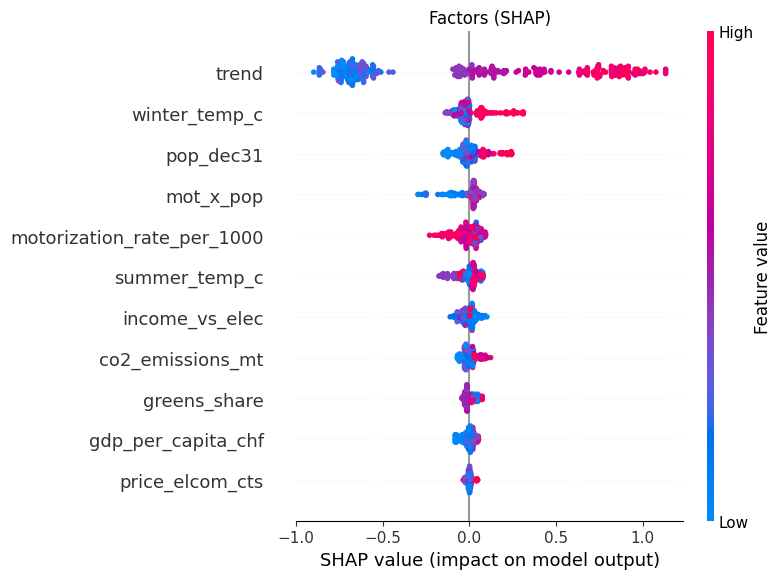


=== OLS Statistical analysis (Multicollinearity & P-values) ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     110.3
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          1.39e-103
Time:                        16:29:42   Log-Likelihood:                -114.91
No. Observations:                 343   AIC:                             253.8
Df Residuals:                     331   BIC:                             299.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import statsmodels.api as sm

# Imports for Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from scipy.stats import uniform, randint

# ============================================================
# 0. Setup and loading the data
# ============================================================
csv_path = INTER / "master_panel_2015_2024.csv"
assert csv_path.exists(), f"Missing file: {csv_path}"
df = pd.read_csv(csv_path)

if not csv_path.exists():
    raise FileNotFoundError(f"Can't find: {csv_path}")

print("Loading the data...")
df = pd.read_csv(csv_path)

# Initial setup
df_model = df.copy()
# Cleaning
df_model = df_model.dropna(subset=["canton_code", "ev_reg_share"]).reset_index(drop=True)

# Target variables and groups
df_model["ev_reg_share"] = df_model["ev_reg_share"].astype(float)
y = df_model["ev_reg_share"].values
df_model["trend"] = df_model["year"] - df_model["year"].min()
groups = df_model["canton_code"].values
gkf = GroupKFold(n_splits=5)

# Standardised assessment function
def evaluate_model(model, X, y, cv, groups, model_name):
    r2s, rmses, maes = [], [], []
    for train_idx, test_idx in cv.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        r2s.append(r2_score(y_test, preds))
        rmses.append(np.sqrt(mean_squared_error(y_test, preds)))
        maes.append(mean_absolute_error(y_test, preds))

    return {
        "Model": model_name,
        "R2": float(np.mean(r2s)),
        "RMSE": float(np.mean(rmses)),
        "MAE": float(np.mean(maes)),
    }

# ============================================================
# 1. CLUSTERING 
# ============================================================
print("Starting clustering (Strategy for saving linear models)...")
canton_profile = df_model.groupby("canton_code")[[
    "gdp_per_capita_chf", "pop_dec31", "motorization_rate_per_1000",
    "summer_temp_c", "co2_emissions_mt"
]].mean()

# Imputation to avoid KMeans crash
imputer = SimpleImputer(strategy="median")
canton_profile_clean = pd.DataFrame(
    imputer.fit_transform(canton_profile),
    columns=canton_profile.columns,
    index=canton_profile.index
)

# K-Means
scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(canton_profile_clean)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
canton_profile["cluster_id"] = kmeans.fit_predict(X_cluster)

# Mapping of clusters
cluster_map = canton_profile["cluster_id"].to_dict()
df_model["canton_cluster"] = df_model["canton_code"].map(cluster_map)
cluster_dummies = pd.get_dummies(df_model["canton_cluster"], prefix="cluster", drop_first=True)

# ============================================================
# 2. FEATURE ENGINEERING & MATRIXES
# ============================================================
df_model = df_model.fillna(df_model.median(numeric_only=True))

df_model["income_vs_elec"] = df_model["gdp_per_capita_chf"] / (df_model["price_elcom_cts"] + 1)
df_model["mot_x_pop"] = df_model["motorization_rate_per_1000"] * np.log(df_model["pop_dec31"] + 1)

base_features = [
    "motorization_rate_per_1000", "gdp_per_capita_chf", "price_elcom_cts",
    "summer_temp_c", "winter_temp_c", "co2_emissions_mt", "greens_share",
    "pop_dec31", "income_vs_elec", "mot_x_pop"
]

# Linear Matrix (Features + CLUSTERS) -> For Ridge/Lasso
X_lin_df = pd.concat([df_model[base_features], cluster_dummies], axis=1)
X_lin = X_lin_df.values

# Non-Linear Matrix (Features + TREND) -> For Trees/GBR
X_nonlin_df = pd.concat([df_model[base_features], df_model[["trend"]]], axis=1)
nonlin_features = X_nonlin_df.columns.tolist() 
X_nonlin = X_nonlin_df.values

# ============================================================
# 3. MODEL TRAINING
# ============================================================
results = [] 
print("Training the models...")

# A. Linear Models (Ridge/Lasso handle multicollinearity)
results.append(evaluate_model(LinearRegression(), X_nonlin, y, gkf, groups, "OLS (Simple)"))
results.append(evaluate_model(RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0]), X_lin, y, gkf, groups, "Ridge CV (Clusters)"))
results.append(evaluate_model(LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1], max_iter=10000), X_lin, y, gkf, groups, "Lasso CV (Clusters)"))

# B. Non-Linear & Advanced Models
results.append(evaluate_model(RandomForestRegressor(n_estimators=300, random_state=42), X_nonlin, y, gkf, groups, "Random Forest"))

mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', alpha=0.01, max_iter=1000, early_stopping=True, random_state=42)
results.append(evaluate_model(mlp, X_nonlin, y, gkf, groups, "Neural Net (MLP)"))

svr = SVR(kernel='rbf', C=10.0, epsilon=0.1)
results.append(evaluate_model(svr, X_nonlin, y, gkf, groups, "SVR (RBF Kernel)"))

kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-10, 1e+1))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2, random_state=42)
results.append(evaluate_model(gpr, X_nonlin, y, gkf, groups, "Gaussian Process"))

# C. Gradient Boosting Tuned 
print("Tuning Gradient Boosting (advanced optimization)...")
param_dist = {
    "n_estimators": randint(200, 1000),         # More trees
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(2, 5),                 # Shallow trees to avoid overfitting
    "subsample": uniform(0.6, 0.4),             # Stochastic Gradient Boosting
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(2, 10),
    "max_features": ["sqrt", "log2", None],     # Randomization of features
    "n_iter_no_change": randint(10, 20),        # Early Stopping (stops if no amelioration)
    "validation_fraction": uniform(0.1, 0.1)    # Data for the early stopping
}

gbr = GradientBoostingRegressor(random_state=42)
search = RandomizedSearchCV(gbr, param_dist, n_iter=25, cv=gkf, scoring="r2", n_jobs=-1, verbose=0, random_state=42)
search.fit(X_nonlin, y, groups=groups)
best_model = search.best_estimator_

results.append(evaluate_model(best_model, X_nonlin, y, gkf, groups, "Gradient Boosting (Tuned)"))

# ============================================================
# 4. EXPORT
# ============================================================
df_models = pd.DataFrame(results)
order = ["OLS (Simple)", "Ridge CV (Clusters)", "Lasso CV (Clusters)", "Random Forest", 
         "Neural Net (MLP)", "SVR (RBF Kernel)", "Gaussian Process", "Gradient Boosting (Tuned)"]
df_models["order"] = df_models["Model"].apply(lambda x: order.index(x) if x in order else 99)
df_models = df_models.sort_values("order").drop(columns="order")

print("\n=== TABLE OF RESULTS ===")
print(df_models)
df_models.to_csv(DATA / "model_results_final.csv", index=False)

# ============================================================
# 5. SHAP & OLS (Diagnostic)
# ============================================================
print("\nGenerating the SHAP graph...")
best_model.fit(X_nonlin, y)
X_analysis = pd.DataFrame(X_nonlin, columns=nonlin_features)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_analysis)

plt.figure(figsize=(10, 6))
plt.title("Factors (SHAP)")
shap.summary_plot(shap_values, X_analysis, show=False)
plt.savefig(OUT / "shap_importance.png", bbox_inches='tight', dpi=300)
plt.show()

print("\n=== OLS Statistical analysis (Multicollinearity & P-values) ===")
X_sm = sm.add_constant(X_analysis)
model_sm = sm.OLS(y, X_sm).fit()
print(model_sm.summary())


In [3]:
# ============================================================
# 5. TABLEAU FINAL & EXPORT
# ============================================================

# Transformation de la liste de résultats en DataFrame
df_models = pd.DataFrame(results)

# Ordre logique pour le rapport (du plus simple au plus complexe/nouveau)
order = [
    "OLS (Simple)",              # Baseline
    "Ridge CV (Clusters)",       # Linéaire avec correction
    "Lasso CV (Clusters)",       # Linéaire avec sélection
    "Random Forest",             # Arbre standard
    "Gradient Boosting (Tuned)", # Le "Champion"
    "Neural Net (MLP)",          # Deep Learning (Complexité)
    "SVR (RBF Kernel)",          # Demande TA
    "Gaussian Process"           # Advanced Analytics
]

# Application du tri personnalisé
# (On gère le cas où un modèle serait absent avec une valeur par défaut 99)
df_models["order"] = df_models["Model"].apply(lambda x: order.index(x) if x in order else 99)
df_models = df_models.sort_values("order").drop(columns="order")

print("\n=== 📊 TABLEAU FINAL — Tous modèles ===")
print(
    df_models.to_string(
        index=False,
        formatters={
            "R2":   "{:.3f}".format,
            "RMSE": "{:.3f}".format,
            "MAE":  "{:.3f}".format,
        },
    )
)

# Export CSV pour inclusion dans Overleaf
export_path = OUT / "model_results_final.csv"
df_models.to_csv(export_path, index=False)

print(f"\n✅ Fichier exporté : {export_path}")


=== 📊 TABLEAU FINAL — Tous modèles ===
                    Model     R2  RMSE   MAE
             OLS (Simple)  0.584 0.446 0.355
      Ridge CV (Clusters) -0.421 0.850 0.688
      Lasso CV (Clusters) -0.066 0.734 0.631
            Random Forest  0.777 0.323 0.239
Gradient Boosting (Tuned)  0.775 0.322 0.250
         Neural Net (MLP)  0.201 0.571 0.440
         SVR (RBF Kernel)  0.356 0.538 0.445
         Gaussian Process -1.134 1.040 0.781

✅ Fichier exporté : C:\Users\hamza\OneDrive\Desktop\projet-ada-hk\data\outputs\model_results_final.csv


🔍 Démarrage de l'analyse des résidus sur le modèle OLS...


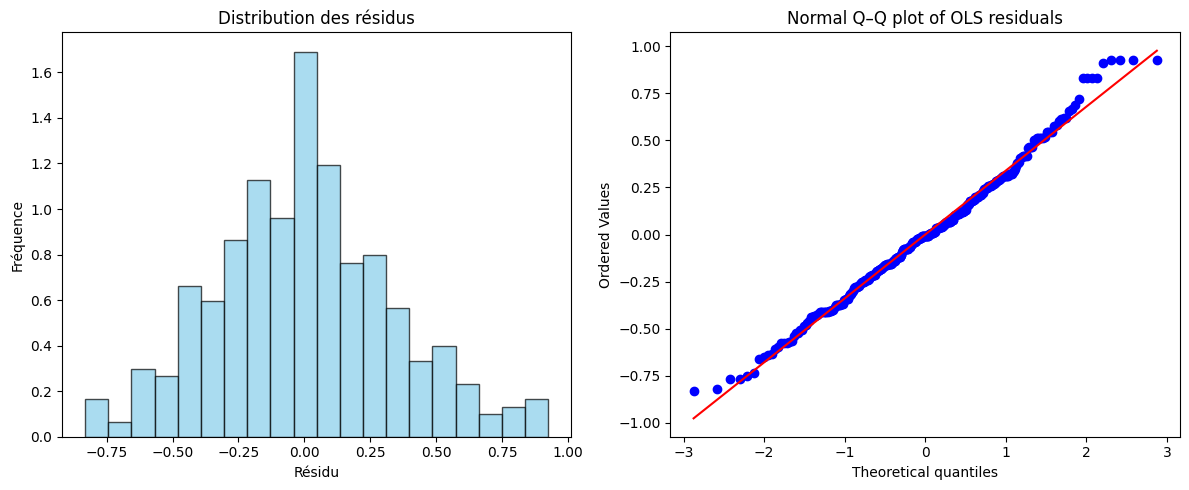

Test Shapiro-Wilk : p-value = 3.6163e-02
⚠️ H0 rejetée : Les résidus ne suivent pas une loi normale parfaite.


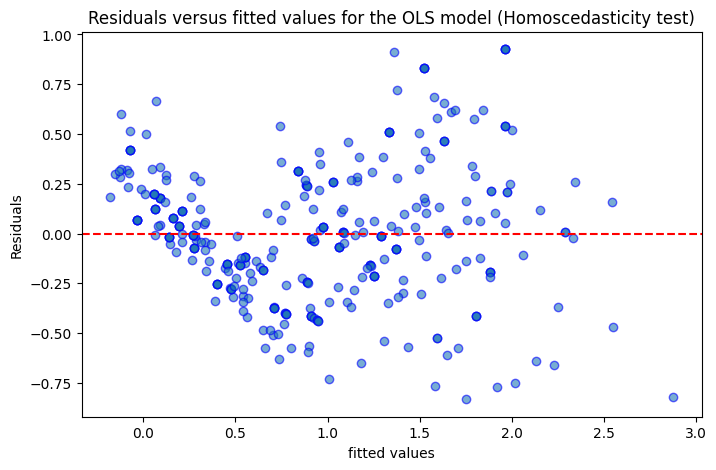

Test Breusch-Pagan : p-value = 2.5776e-09
⚠️ Hétéroscédasticité détectée (La variance des erreurs change).


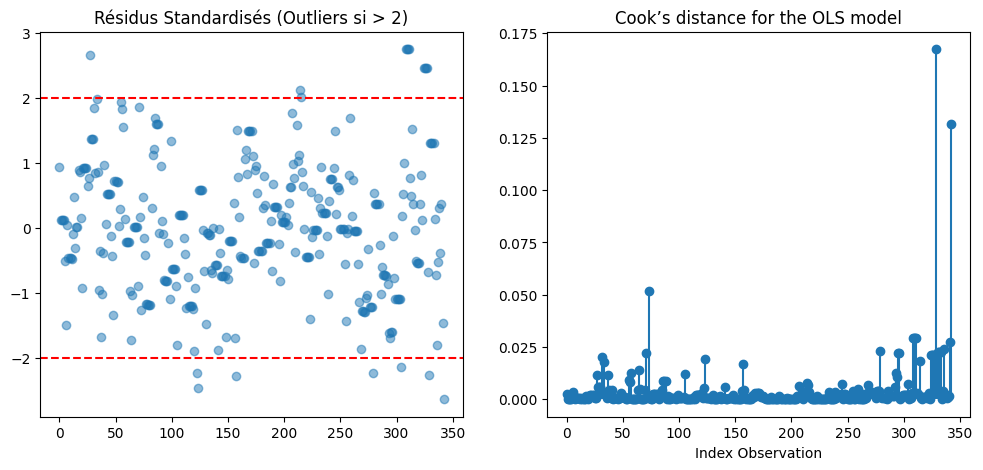

Nombre d'observations influentes (Cook's D > 0.012) : 30

RÉSUMÉ STATISTIQUE DU MODÈLE OLS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     110.3
Date:                Sun, 04 Jan 2026   Prob (F-statistic):          1.39e-103
Time:                        16:29:44   Log-Likelihood:                -114.91
No. Observations:                 343   AIC:                             253.8
Df Residuals:                     331   BIC:                             299.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [4]:
# ============================================================
# 10. DIAGNOSTIC ÉCONOMÉTRIQUE (Version Robuste & Corrigée)
# ============================================================
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import pandas as pd
import numpy as np

print("🔍 Démarrage de l'analyse des résidus sur le modèle OLS...")

# 1. Préparation des données pour Statsmodels
# On utilise X_nonlin car il contient toutes les features pertinentes (y compris le trend)
try:
    # On récupère les noms de colonnes définis précédemment
    cols = nonlin_features
except NameError:
    # Fallback de sécurité si la variable n'existe pas
    cols = [f"Var_{i}" for i in range(X_nonlin.shape[1])]

X_sm_df = pd.DataFrame(X_nonlin, columns=cols)
X_sm = sm.add_constant(X_sm_df)  # Ajout de la constante (intercept)

# 2. Fit du modèle OLS complet sur tout le dataset
model_sm = sm.OLS(y, X_sm).fit()

# --- CORRECTION CRITIQUE (Aplatissement des arrays) ---
# .values.flatten() garantit que ce sont des tableaux 1D simples
# Cela évite les erreurs "Multi-dimensional indexing" avec matplotlib/seaborn
residuals = model_sm.resid.values.flatten()
y_pred = model_sm.fittedvalues.values.flatten()

# --- A. TEST DE NORMALITÉ ---
plt.figure(figsize=(12, 5))

# Histogramme (Version Matplotlib standard, plus robuste ici)
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution des résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")

# QQ-Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q–Q plot of OLS residuals")
plt.tight_layout()
plt.show()

# Test de Shapiro-Wilk
stat, p_shapiro = shapiro(residuals)
print(f"Test Shapiro-Wilk : p-value = {p_shapiro:.4e}")
if p_shapiro > 0.05:
    print("✔️ H0 acceptée : Les résidus sont distribués normalement.")
else:
    print("⚠️ H0 rejetée : Les résidus ne suivent pas une loi normale parfaite.")

# --- B. TEST D'HOMOSCÉDASTICITÉ (Breusch-Pagan) ---
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='b')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("fitted values")
plt.ylabel("Residuals")
plt.title("Residuals versus fitted values for the OLS model (Homoscedasticity test)")
plt.show()

# Test Breusch-Pagan
# Note: model_sm.resid est une Series pandas, model_sm.model.exog est un array numpy
# La fonction het_breuschpagan gère bien ces formats natifs de statsmodels
bp_test = het_breuschpagan(model_sm.resid, model_sm.model.exog)
print(f"Test Breusch-Pagan : p-value = {bp_test[1]:.4e}")
if bp_test[1] > 0.05:
    print("✔️ Homoscédasticité confirmée (Variance constante).")
else:
    print("⚠️ Hétéroscédasticité détectée (La variance des erreurs change).")

# --- C. INDÉPENDANCE ET INFLUENCE (Cook's Distance) ---
# Résidus standardisés
influence = model_sm.get_influence()
# On accède directement aux attributs internes pour éviter les soucis d'index
resid_std = influence.resid_studentized_internal

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(resid_std, marker='o', linestyle='', alpha=0.5)
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='red', linestyle='--')
plt.title("Résidus Standardisés (Outliers si > 2)")

# Cook's Distance
cooks = influence.cooks_distance[0]

plt.subplot(1, 2, 2)
plt.stem(np.arange(len(cooks)), cooks, basefmt=" ")
plt.title("Cook’s distance for the OLS model")
plt.xlabel("Index Observation")
plt.show()

# Identifier les points influents (seuil classique 4/n)
threshold = 4 / len(y)
influential_points = np.where(cooks > threshold)[0]
print(f"Nombre d'observations influentes (Cook's D > {threshold:.3f}) : {len(influential_points)}")

# --- D. RÉSUMÉ STATISTIQUE COMPLET ---
print("\n" + "="*40)
print("RÉSUMÉ STATISTIQUE DU MODÈLE OLS")
print("="*40)
print(model_sm.summary())

In [5]:
vars_desc = [c for c in df_model.columns if c in [
    "y",
    "price_elcom_cts",
    "gdp_per_capita_chf",
    "motorization_rate_per_1000",
    "pop_dec31",
    "summer_temp_c",
    "winter_temp_c",
    "co2_emissions_mt",
    "greens_share"
]]

print("Variables utilisées :", vars_desc)

desc_table = (
    df_model[vars_desc]
    .describe()
    .loc[["count", "mean", "std", "min", "max"]]
    .T
)

desc_table


Variables utilisées : ['motorization_rate_per_1000', 'gdp_per_capita_chf', 'pop_dec31', 'greens_share', 'summer_temp_c', 'winter_temp_c', 'co2_emissions_mt', 'price_elcom_cts']


,count,mean,std,min,max
motorization_rate_per_1000,343.0,559.639177,69.021539,322.530008,7.651031e+02
gdp_per_capita_chf,343.0,87449.880070,35642.310222,52365.853080,2.349447e+05
pop_dec31,343.0,303752.819242,330093.681065,15974.000000,1.620020e+06
greens_share,343.0,0.018525,0.009223,0.000000,5.882353e-02
summer_temp_c,343.0,17.553440,1.976919,12.570000,2.013000e+01
winter_temp_c,343.0,0.736968,1.526900,-2.000000,2.930000e+00
co2_emissions_mt,343.0,1.500087,1.636811,0.080000,7.640000e+00
price_elcom_cts,343.0,8.965798,1.112764,6.461467,1.307427e+01
